# Model Training - Sub model 1

## Load the Dataset 1

In [ ]:
import pandas as pd

TB_HC_OD = pd.read_csv(r'..\..\Datasets\train\balanced\TB_HC_OD.csv')

## Separate features and target

In [18]:
# Separate features and target in each dataset

X_TB_HC_OD = TB_HC_OD.drop(columns=['TB_Status'])
y_TB_HC_OD = TB_HC_OD['TB_Status']

## Training the model using best algorithm

In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle

In [20]:
import numpy as np

selected_features_path = r"..\..\Saved_files\selected_features_TB_HC_OD.csv"

# Load selected features
selected_features = pd.read_csv(selected_features_path)
selected_feature_names = selected_features['Selected Features'].tolist()
X_TB_HC_OD = X_TB_HC_OD[selected_feature_names]

# Split data
X_train_TB_Status, X_test_TB_Status, y_train_TB_Status, y_test_TB_Status = train_test_split(
    X_TB_HC_OD, y_TB_HC_OD, test_size=0.2, random_state=42, stratify=y_TB_HC_OD
)

# Feature selection using Extra Trees Classifier
feature_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=42), threshold="mean")
X_train_selected = feature_selector.fit_transform(X_train_TB_Status, y_train_TB_Status)
X_test_selected = feature_selector.transform(X_test_TB_Status)

# ✅ Get selected feature names
selected_mask = feature_selector.get_support()
selected_feature_names_final = np.array(selected_feature_names)[selected_mask]

# Display selected feature information
print("\n" + "="*60)
print("🔍 FEATURE SELECTION RESULTS (Extra Trees Classifier)")
print("="*60)
print(f"Total features before selection : {len(selected_feature_names)}")
print(f"Total features after selection  : {len(selected_feature_names_final)}\n")
print("Selected Features:")
for i, feature in enumerate(selected_feature_names_final, start=1):
    print(f"{i}. {feature}")
print("="*60 + "\n")

# Save feature selector
feature_selector_TB_Status_path = r"..\..\Saved_files\feature_selector_TB_Status.pkl"
with open(feature_selector_TB_Status_path, 'wb') as file:
    pickle.dump(feature_selector, file)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_TB_Status)
y_test_encoded = label_encoder.transform(y_test_TB_Status)

# Save label encoder
label_encoder_TB_Status_path = r"..\..\Saved_files\label_encoder_TB_Status.pkl"
with open(label_encoder_TB_Status_path, 'wb') as file:
    pickle.dump(label_encoder, file)

# Define TB status labels
tb_status_labels = ["TB", "Healthy Control", "Other Diseases"]

print(f"Training set shape: {X_train_selected.shape}")
print(f"Test set shape: {X_test_selected.shape}")
print(f"Class distribution in training: {dict(zip(tb_status_labels, np.bincount(y_train_encoded)))}")



🔍 FEATURE SELECTION RESULTS (Extra Trees Classifier)
Total features before selection : 35
Total features after selection  : 14

Selected Features:
1. ILMN_1654389
2. ILMN_1799848
3. ILMN_1691364
4. ILMN_2388547
5. ILMN_1806040
6. ILMN_1776157
7. ILMN_2114568
8. ILMN_1811489
9. ILMN_1670305
10. ILMN_1756953
11. ILMN_1676448
12. ILMN_1731064
13. ILMN_1664543
14. ILMN_2058782

Training set shape: (1725, 14)
Test set shape: (432, 14)
Class distribution in training: {'TB': 575, 'Healthy Control': 575, 'Other Diseases': 575}


In [21]:
# --- Create Optimized SVM Pipeline with Best Hyperparameters ---
model_TB_Status = Pipeline([
    ('scaler', StandardScaler()),  # Feature Scaling (essential for SVM)
    ('svm', SVC(
        C=10,                    # Best from hyperparameter tuning
        gamma='auto',            # Best from hyperparameter tuning  
        kernel='rbf',            # Best from hyperparameter tuning
        probability=True,        # Enable probability predictions
        random_state=42,
        cache_size=1000,         # Increase cache for faster training
        decision_function_shape='ovr'  # One-vs-rest for multi-class
    ))
])

# --- Train the Model ---
print("Training SVM model with optimal hyperparameters...")
model_TB_Status.fit(X_train_selected, y_train_encoded)

# --- Evaluate on Test Set ---
y_pred_best_TB_Status = model_TB_Status.predict(X_test_selected)
y_pred_proba = model_TB_Status.predict_proba(X_test_selected)

print("\n" + "="*60)
print("SUB-MODEL 1 (TB_HC_OD) - OPTIMIZED SVM PERFORMANCE")
print("="*60)

# Detailed classification report
print("\nBest TB_Status Classification Report:")
print(classification_report(y_test_encoded, y_pred_best_TB_Status, target_names=tb_status_labels))

# Individual metrics
accuracy = accuracy_score(y_test_encoded, y_pred_best_TB_Status)
precision = precision_score(y_test_encoded, y_pred_best_TB_Status, average='weighted')
recall = recall_score(y_test_encoded, y_pred_best_TB_Status, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_best_TB_Status, average='weighted')

print(f"\nOverall Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Class-wise performance
print(f"\nClass-wise Performance:")
for i, label in enumerate(tb_status_labels):
    class_precision = precision_score(y_test_encoded, y_pred_best_TB_Status, average=None)[i]
    class_recall = recall_score(y_test_encoded, y_pred_best_TB_Status, average=None)[i]
    class_f1 = f1_score(y_test_encoded, y_pred_best_TB_Status, average=None)[i]
    print(f"{label:15} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1: {class_f1:.4f}")

# --- Save the Trained Model ---
model_save_path = r"..\..\Saved_files\best_sub_model_1.pkl"
with open(model_save_path, 'wb') as file:
    pickle.dump(model_TB_Status, file)

print(f"\n✅ Trained model saved to {model_save_path}")


Training SVM model with optimal hyperparameters...

SUB-MODEL 1 (TB_HC_OD) - OPTIMIZED SVM PERFORMANCE

Best TB_Status Classification Report:
                 precision    recall  f1-score   support

             TB       0.85      0.97      0.91       144
Healthy Control       0.80      0.76      0.78       144
 Other Diseases       0.81      0.73      0.77       144

       accuracy                           0.82       432
      macro avg       0.82      0.82      0.82       432
   weighted avg       0.82      0.82      0.82       432


Overall Metrics:
Accuracy:  0.8218
Precision: 0.8195
Recall:    0.8218
F1-Score:  0.8186

Class-wise Performance:
TB              - Precision: 0.8537, Recall: 0.9722, F1: 0.9091
Healthy Control - Precision: 0.7971, Recall: 0.7639, F1: 0.7801
Other Diseases  - Precision: 0.8077, Recall: 0.7292, F1: 0.7664

✅ Trained model saved to ..\..\Saved_files\best_sub_model_1.pkl


In [22]:
# Extract the scaler from the pipeline
scaler_TB_Status = model_TB_Status.named_steps['scaler']

# Define paths to save the scaler
scaler_save_path_TB_Status = r"..\..\Saved_files\scalar\scaler_TB_Status.pkl"

# Save the scaler
with open(scaler_save_path_TB_Status, 'wb') as file:
    pickle.dump(scaler_TB_Status, file)

print(f"Scaler for TB Status saved to {scaler_save_path_TB_Status}")


Scaler for TB Status saved to ..\..\Saved_files\scalar\scaler_TB_Status.pkl


## Evaluation of the sub model

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate the model and display metrics
def evaluate_model(y_true, y_pred, label):
    print(f"\n--- Evaluation Metrics for {label} ---")
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\n")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


--- Model Evaluation ---

--- Evaluation Metrics for TB_Status ---
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
F1 Score: 0.82




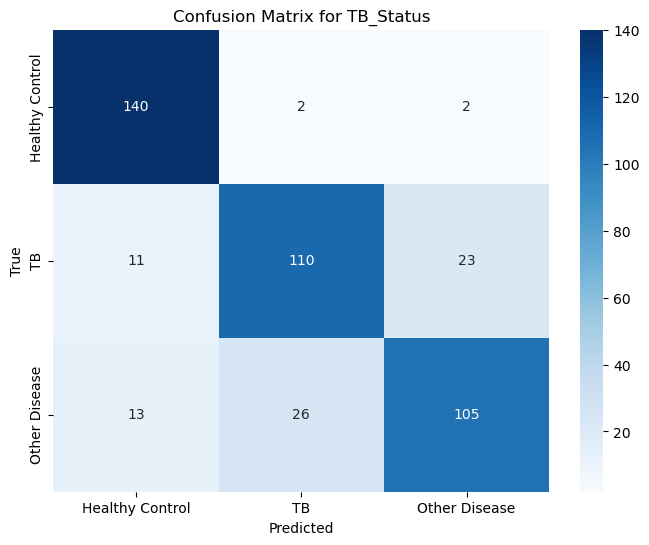

In [24]:
# Evaluate models using test datasets
print("\n--- Model Evaluation ---")
# TB_Status Evaluation using the best model
y_pred_TB_Status = model_TB_Status.predict(X_test_selected)

# Convert encoded predictions back to text labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_TB_Status)

# Evaluate using original labels
evaluate_model(y_test_labels, y_pred_labels, "TB_Status")

